In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial, lru_cache
from scipy import integrate
import plotly.graph_objects as go
from tqdm import tqdm
import scipy.interpolate
import pandas as pd
import seaborn as sns
from tqdm import tqdm


In [2]:
# correct as per paper Normal Inverse Gaussian Distributions and Stochastic Volatility Modelling
class invgauss:
    def __init__(self, delta, gamma):
        self.mu = delta/gamma
        self._lambda = self.mu**3 * gamma**3 / delta

    def rvs(self, size):
        nu = stats.norm.rvs(size=size)
        y = nu**2

        x = self.mu + self.mu**2*y/(2*self._lambda) - (self.mu/(2*self._lambda))*np.sqrt(4*self.mu*self._lambda*y + self.mu**2*y**2)
        z = stats.uniform(0,1).rvs(size)

        i = z <= self.mu/(self.mu+x)
        IGs = self.mu**2/x
        IGs[i] = x[i]
        return IGs

    def pdf(self, x):
        part1 = np.sqrt(self._lambda/(2*np.pi*x**3))
        part2 = np.exp(-self._lambda*(x-self.mu)**2/(2*(self.mu**2)*x))
        return part1*part2

In [6]:
class norminvgauss:
    def __init__(self, alpha, beta, mu, delta):
        self.alpha = alpha
        self.beta = beta
        self.mu = mu
        self.delta = delta
        self.gamma = np.sqrt(alpha**2 - beta**2)

        
    def pdf(self, x):
        part1 = self.delta*self.alpha * np.exp(self.delta*self.gamma +  self.beta*(x-self.mu))
        part2 = scipy.special.kv(1.0, self.alpha*np.sqrt(self.delta**2 + (x-self.mu)**2))
        part3 = np.pi * np.sqrt(self.delta**2 + (x-self.mu)**2)
        return part1 * part2 / part3
    
    def cdf(self, y):
        return scipy.integrate.quad(self.pdf, -np.inf, y)[0]
    
    def mean(self):
        # Analytical 
        return self.mu+self.delta*self.beta/self.gamma
    
    def var(self):
        return (self.delta*self.alpha**2/self.gamma**3)
    
    def std(self):
        return np.sqrt(self.var())
    
    def skewness(self):
        return 3*self.beta / (self.alpha*np.sqrt(self.delta*self.gamma))
    
    def kurtosis(self):
        return 3*(1+4*self.beta**2/self.alpha**2)/(self.delta*self.gamma)
    
    def normalise(self):
        # Standardised NIG for CF approximation use
        self.a = self.std()
        self.b = self.mean()
        self.standardisedNIG = norminvgauss(alpha=self.alpha*self.a,
                                          beta=self.beta*self.a,
                                          mu=(self.mu-self.b)/self.a,
                                          delta=self.delta/self.a)

    def rvs(self, size):
        z = invgauss(delta=self.delta, gamma=self.gamma).rvs(size=size)
        x = stats.norm(loc=self.mu + self.beta*z, scale= np.sqrt(z)).rvs(size=size)
        return x
    
    
    def ppf(self, q):
        fn_toopt = lambda x: (self.cdf(x) - q)**2
        result  = scipy.optimize.minimize(fn_toopt, x0=self.mean(), tol=1e-10)
        return result.x

In [16]:
# correct as per wiki
# class invgauss:
#     def __init__(self, mu, _lambda):
#         self.mu = mu
#         self._lambda = _lambda

#     def rvs(self, size):
#         nu = stats.norm.rvs(size=size)
#         y = nu**2

#         x = self.mu + self.mu**2*y/(2*self._lambda) - (self.mu/(2*self._lambda))*np.sqrt(4*self.mu*self._lambda*y + self.mu**2*y**2)
#         z = stats.uniform(0,1).rvs(size)

#         i = z <= self.mu/(self.mu+x)
#         IGs = self.mu**2/x
#         IGs[i] = x[i]

#         return IGs

#     def pdf(self, x):
#         part1 = np.sqrt(self._lambda/(2*np.pi*x**3))
#         part2 = np.exp(-self._lambda*(x-self.mu)**2/(2*(self.mu**2)*x))
#         return part1*part2

In [56]:
%%time
alpha = 1
beta  = 0.5
mu    = 0
delta = 1
x     = 1
loc = norminvgauss(alpha, beta, mu, delta).mean()
scale = norminvgauss(alpha, beta, mu, delta).std()

# q_arr = np.linspace(0.001,.999,100)
# q_arr_norm = stats.norm(loc, scale).ppf(q_arr)
result = np.zeros(100)
NIG = norminvgauss(alpha, beta, mu, delta)
for i,q in enumerate(q_arr):
    fn_toopt = lambda x: (NIG.cdf(x) - q)**2
    x  = scipy.optimize.minimize(fn_toopt, x0=loc, tol=1e-10)
    result[i] = x.x

CPU times: user 3.82 s, sys: 31.8 ms, total: 3.86 s
Wall time: 3.86 s


In [54]:
%%time
scipy.optimize.minimize(fn_toopt, x0=q_arr_norm[i], tol=1e-10)

CPU times: user 128 ms, sys: 2.8 ms, total: 130 ms
Wall time: 129 ms


      fun: 5.762736085118747e-19
 hess_inv: array([[1164905.85195291]])
      jac: array([-9.85532744e-13])
  message: 'Optimization terminated successfully.'
     nfev: 60
      nit: 15
     njev: 20
   status: 0
  success: True
        x: array([8.19328325])

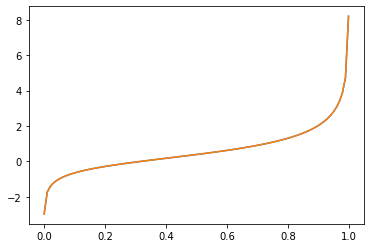

In [60]:
plt.plot(q_arr, result)
plt.plot([NIG.cdf(r) for r in result], result)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

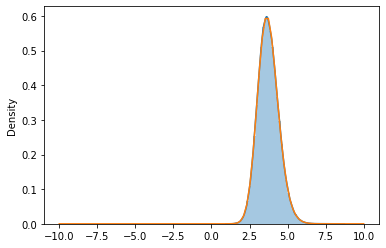

In [31]:
alpha = 10
beta  = 5
mu    = 2
delta = 3
gamma = np.sqrt(alpha**2 - beta**2)

size = 500000
# z = invgauss(delta=delta, gamma=gamma).rvs(size=size)
# x = stats.norm(loc=mu + beta*z, scale= np.sqrt(z)).rvs(size=size)
# sns.distplot(x)


NIG_law = norminvgauss(alpha=alpha, beta=beta, mu=mu, delta=delta)
x = NIG_law.rvs(size=size)
sns.distplot(x)

u = np.linspace(-10,10,100)
plt.plot(u,NIG_law.pdf(u))

In [146]:
%%time
Q = np.linspace(0.001,.999,100)
x0= NIG_law.mean()
results = []

for q in Q:
    def loss(x, q):
        return (NIG_law.cdf(x) - q)**2
    loss_opt = partial(loss, q=q)
    res = scipy.optimize.minimize(loss_opt, x0=x0, method="Nelder-Mead")
    results.append(res.x[0])

CPU times: user 2.69 s, sys: 14.2 ms, total: 2.7 s
Wall time: 2.7 s


In [155]:
np.argmax(Q-C)

47

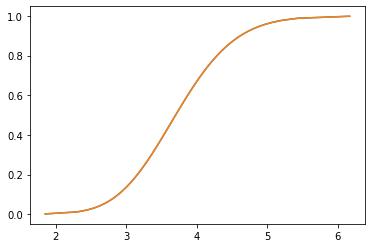

In [150]:
plt.plot(results,Q)
plt.plot(results, C)

In [148]:
C = []
for r in results:
    C.append(NIG_law.cdf(r))

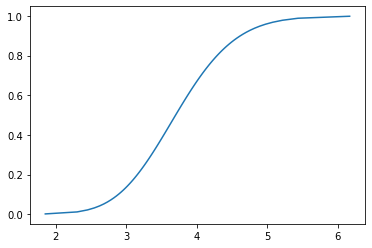

In [149]:
plt.plot(results, C)

In [20]:
print(np.mean(x), mu+delta*beta/gamma)
print(np.var(x), delta*alpha**2/gamma**3)
print(stats.skew(x), 3*beta/(alpha*np.sqrt(delta*gamma)))
print(stats.kurtosis(x), 3*(1+4*beta**2/alpha**2)/(delta*gamma))

3.7328146815793004 3.732050807568877
0.46233189471577574 0.46188021535170054
0.29718140063494336 0.29428309563827115
0.23005778027304302 0.2309401076758503


In [21]:
b = mu+delta*beta/gamma
a = (delta*alpha**2/gamma**3)**0.5
NIG_law_2 = norminvgauss(alpha=alpha*a, beta=beta*a, mu=(mu-b)/a, delta=delta/a)
x2 = NIG_law_2.rvs(size=size)

NIG_law_2.var()

1.0

In [22]:
NIG_law.normalise()

In [25]:
NIG_law.standardisedNIG.var()

1.0

In [4]:
data = pd.read_csv('../processed_data/btc_future_crix.csv')
btc  = data.iloc[:,-3]
brr  = data.iloc[:,-2]
crix = data.iloc[:,-1]

from statsmodels.distributions.empirical_distribution import ECDF

U = ECDF(btc)(btc)
V = ECDF(brr)(brr)

# rho = 0.5
# ratio = np.sqrt(1-rho)/np.sqrt(rho)
# alpha = 1
# beta = 0.5
# alpha2 = ratio*alpha
# beta2 = ratio*beta
# gamma = np.sqrt(alpha**2 - beta**2)
# mu1 = -beta*gamma**2/alpha**2
# mu2 = ratio*mu1
# delta1 = gamma**3/alpha**2
# delta2 = ratio*delta1

# X1_law = norminvgauss(alpha/np.sqrt(rho),beta/np.sqrt(rho),
#                       -beta*gamma**2/np.sqrt(rho),gamma**3/(alpha**2*np.sqrt(rho)))
# X2_law = norminvgauss(alpha/np.sqrt(rho),beta/np.sqrt(rho),
#                       -beta*gamma**2/np.sqrt(rho),gamma**3/(alpha**2*np.sqrt(rho)))
# e1_law = norminvgauss(alpha2,beta2,mu2,delta2)
# e2_law = norminvgauss(alpha2,beta2,mu2,delta2)


# A = []
# B = []
# for i in tqdm(range(len(U))):
#     A.append(X1_law.ppf(U[i]))
#     B.append(X2_law.ppf(V[i]))


# def joint_density_toopt(u, v, rho):
#     if u==0:
#         u = 0.001
#     if u==1:
#         u = 0.99
#     if v==0:
#         v = 0.001
#     if v==1:
#         v = 0.99
        
#     a = X1_law.ppf(u)
#     b = X2_law.ppf(v)
#     part1 = 1/X1_law.pdf(a)
#     part2 = 1/X2_law.pdf(b)

#     part3a_fn = lambda m: e1_law.pdf((a-np.sqrt(rho)*m)/np.sqrt(1-rho))
#     part3b_fn = lambda m: e2_law.pdf((b-np.sqrt(rho)*m)/np.sqrt(1-rho))
#     part3 = scipy.integrate.quad(lambda m: part3a_fn(m)*part3b_fn(m),
#                                  -np.inf, np.inf)[0]

#     return part1*part2*part3

# def joint_density_toopt(a, b, rho):
#     part1 = 1/X1_law.pdf(a)
#     part2 = 1/X2_law.pdf(b)

#     part3a_fn = lambda m: e1_law.pdf((a-np.sqrt(rho)*m)/np.sqrt(1-rho))
#     part3b_fn = lambda m: e2_law.pdf((b-np.sqrt(rho)*m)/np.sqrt(1-rho))
#     part3 = scipy.integrate.quad(lambda m: part3a_fn(m)*part3b_fn(m),
#                                  -np.inf, np.inf)[0]

#     return part1*part2*part3

In [9]:
%%time
ll = []
rho_arr = np.linspace(0.42,0.58,11)
for rho in rho_arr:
    ratio = np.sqrt(1-rho)/np.sqrt(rho)
    alpha = 1
    beta = 0.5
    alpha2 = ratio*alpha
    beta2 = ratio*beta
    gamma = np.sqrt(alpha**2 - beta**2)
    mu1 = -beta*gamma**2/alpha**2
    mu2 = ratio*mu1
    delta1 = gamma**3/alpha**2
    delta2 = ratio*delta1

    X1_law = norminvgauss(alpha/np.sqrt(rho),beta/np.sqrt(rho),
                          -beta*gamma**2/np.sqrt(rho),gamma**3/(alpha**2*np.sqrt(rho)))
    X2_law = norminvgauss(alpha/np.sqrt(rho),beta/np.sqrt(rho),
                          -beta*gamma**2/np.sqrt(rho),gamma**3/(alpha**2*np.sqrt(rho)))
    e1_law = norminvgauss(alpha2,beta2,mu2,delta2)
    e2_law = norminvgauss(alpha2,beta2,mu2,delta2)

    A = []
    B = []
    for i in tqdm(range(len(U))):
        A.append(X1_law.ppf(U[i]))
        B.append(X2_law.ppf(V[i]))

    def joint_density_toopt(a, b, rho):
        part1 = 1/X1_law.pdf(a)
        part2 = 1/X2_law.pdf(b)

        part3a_fn = lambda m: e1_law.pdf((a-np.sqrt(rho)*m)/np.sqrt(1-rho))
        part3b_fn = lambda m: e2_law.pdf((b-np.sqrt(rho)*m)/np.sqrt(1-rho))
        part3 = scipy.integrate.quad(lambda m: part3a_fn(m)*part3b_fn(m),
                                     -np.inf, np.inf)[0]
        return part1*part2*part3

    result = []
    for i in tqdm(range(len(A))):
        result.append(joint_density_toopt(A[i], B[i], rho))
    result = np.array(result).reshape(-1)
    ll.append(np.nansum(np.log(result)))


 45%|████▍     | 288/645 [00:33<00:57,  6.16it/s]


 87%|████████▋ | 563/645 [01:06<00:09,  9.07it/s]


100%|██████████| 645/645 [01:16<00:00,  8.42it/s]

  0%|          | 0/645 [00:00<?, ?it/s]/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

overflow encountered in exp

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning:

invalid value encountered in multiply

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: IntegrationWarning:

The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


 49%|████▉     | 316/645 [00:14<00:18, 18.03it/s]


100%|██████████| 645/645 [00:30<00:00, 21.28it/s]

 15%|█▌        | 98/645 [00:10<00:50, 10.79it/s]


 61%|██████    | 392/645 [00:42<00:23, 10.97it/s]


100%|██████████| 645/645 [01:08<00:00,  9.42it/s]

  1%|          | 7/645 [00:00<00:09, 65.74it/s]/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

overflow encountered in exp

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning:

invalid value encountered in multiply

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: IntegrationWarning:

The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


 17%|█▋        | 109/645 [00:03<00:23, 22.66it/s]


100%|██████████| 645/645 [00:20<00:00, 31.95it/s]

 14%|█▍        | 89/645 [00:08<00:55,  9.98it/s]


 60%|█████▉    | 384/645 [00:41<00:28,  9.12it/s]


100%|██████████| 645/645 [01:09<00:00,  9.23it/s]

  1%|          | 7/645 [00:00<00:09, 69.43it/s]/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

overflow encountered in exp

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning:

invalid value encountered in multiply

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: IntegrationWarning:

The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


 11%|█         | 72/645 [00:01<00:13, 41.19it/s]


100%|██████████| 645/645 [00:19<00:00, 33.23it/s]

 11%|█▏        | 74/645 [00:08<00:56, 10.06it/s]


 54%|█████▍    | 350/645 [00:43<00:27, 10.89it/s]


 99%|█████████▉| 640/645 [01:16<00:00,  7.60it/s]


100%|██████████| 645/645 [01:17<00:00,  8.33it/s]

  2%|▏         | 13/645 [00:00<00:10, 60.18it/s]/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

overflow encountered in exp

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning:

invalid value encountered in multiply

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: IntegrationWarning:

The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


100%|██████████| 645/645 [00:19<00:00, 33.07it/s]

  4%|▍         | 29/645 [00:02<01:01, 10.09it/s]


 48%|████▊     | 307/645 [00:37<00:48,  6.94it/s]


 92%|█████████▏| 593/645 [01:10<00:04, 10.67it/s]


100%|██████████| 645/645 [01:18<00:00,  8.27it/s]

  2%|▏         | 11/645 [00:00<00:12, 49.92it/s]/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

overflow encountered in exp

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning:

invalid value encountered in multiply

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: IntegrationWarning:

The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


 87%|████████▋ | 560/645 [00:17<00:02, 33.94it/s]


100%|██████████| 645/645 [00:20<00:00, 32.23it/s]

 39%|███▉      | 250/645 [00:30<01:13,  5.38it/s]


 73%|███████▎  | 473/645 [01:09<00:34,  5.03it/s]


100%|██████████| 645/645 [01:41<00:00,  6.39it/s]

  2%|▏         | 13/645 [00:00<00:15, 40.05it/s]/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

overflow encountered in exp

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning:

invalid value encountered in multiply

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: IntegrationWarning:

The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


  5%|▌         | 35/645 [00:01<00:28, 21.66it/s]


100%|██████████| 645/645 [00:25<00:00, 25.64it/s]

  2%|▏         | 15/645 [00:01<01:15,  8.33it/s]


 48%|████▊     | 307/645 [00:36<00:39,  8.58it/s]


 95%|█████████▍| 611/645 [01:08<00:04,  6.96it/s]


100%|██████████| 645/645 [01:12<00:00,  8.89it/s]

  2%|▏         | 14/645 [00:00<00:09, 64.93it/s]/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

overflow encountered in exp

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning:

invalid value encountered in multiply

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: IntegrationWarning:

The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


100%|██████████| 645/645 [00:17<00:00, 35.98it/s]

  1%|          | 7/645 [00:00<01:13,  8.64it/s]


 47%|████▋     | 302/645 [00:33<00:40,  8.57it/s]


 93%|█████████▎| 601/645 [01:06<00:04,  9.50it/s]


100%|██████████| 645/645 [01:12<00:00,  8.85it/s]

  1%|▏         | 9/645 [00:00<00:15, 40.13it/s]/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

overflow encountered in exp

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning:

invalid value encountered in multiply

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: IntegrationWarning:

The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


 93%|█████████▎| 599/645 [00:17<00:01, 28.92it/s]


100%|██████████| 645/645 [00:19<00:00, 33.60it/s]

 42%|████▏     | 271/645 [00:30<00:59,  6.30it/s]


 88%|████████▊ | 567/645 [01:03<00:05, 14.29it/s]


100%|██████████| 645/645 [01:13<00:00,  8.73it/s]

  2%|▏         | 14/645 [00:00<00:10, 58.30it/s]/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

overflow encountered in exp

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning:

invalid value encountered in multiply

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: IntegrationWarning:

The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


 84%|████████▍ | 541/645 [00:15<00:03, 28.91it/s]


100%|██████████| 645/645 [00:18<00:00, 35.38it/s]

 39%|███▉      | 254/645 [00:30<00:55,  7.01it/s]


 87%|████████▋ | 561/645 [01:05<00:06, 12.84it/s]


100%|██████████| 645/645 [01:15<00:00,  8.59it/s]

  1%|          | 7/645 [00:00<00:09, 65.60it/s]/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

overflow encountered in exp

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning:

invalid value encountered in multiply

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: IntegrationWarning:

The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


 91%|█████████ | 584/645 [00:14<00:01, 50.64it/s]


100%|██████████| 645/645 [00:16<00:00, 38.45it/s]

 44%|████▎     | 282/645 [00:31<00:57,  6.36it/s]


 90%|████████▉ | 579/645 [01:06<00:09,  7.11it/s]


100%|██████████| 645/645 [01:14<00:00,  8.69it/s]

  2%|▏         | 13/645 [00:00<00:11, 56.16it/s]/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

overflow encountered in exp

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning:

invalid value encountered in multiply

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: IntegrationWarning:

The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


 88%|████████▊ | 565/645 [00:16<00:02, 32.80it/s]


100%|██████████| 645/645 [00:19<00:00, 33.22it/s]

CPU times: user 17min 28s, sys: 15.1 s, total: 17min 43s
Wall time: 17min 46s


[213.49225312887654, 337.0078268253728, 380.9124205689221, 376.52687618606046, 347.549378075746, 334.7283868065514, 323.85067865646226, 327.78666841931226, 317.2501937474608, 300.9412355326281, 289.6698407443139]


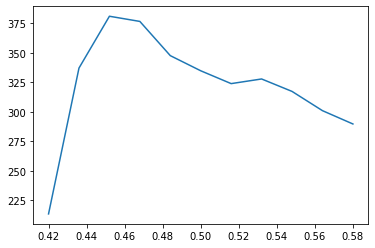

In [22]:
# ll=[213.49225312887654, 337.0078268253728, 380.9124205689221, 376.52687618606046, 347.549378075746, 334.7283868065514, 323.85067865646226, 327.78666841931226, 317.2501937474608, 300.9412355326281, 289.6698407443139]
plt.plot(rho_arr, ll)
print(ll)

In [29]:
%%time
# rho = rho_arr[np.argmax(ll)]
rho=0.45
ll = []
alpha_arr = np.linspace(0.55,50,1)
for alpha in alpha_arr:
    ratio = np.sqrt(1-rho)/np.sqrt(rho)
#     alpha = 1
    beta = 0.5
    alpha2 = ratio*alpha
    beta2 = ratio*beta
    gamma = np.sqrt(alpha**2 - beta**2)
    mu1 = -beta*gamma**2/alpha**2
    mu2 = ratio*mu1
    delta1 = gamma**3/alpha**2
    delta2 = ratio*delta1

    X1_law = norminvgauss(alpha/np.sqrt(rho),beta/np.sqrt(rho),
                          -beta*gamma**2/np.sqrt(rho),gamma**3/(alpha**2*np.sqrt(rho)))
    X2_law = norminvgauss(alpha/np.sqrt(rho),beta/np.sqrt(rho),
                          -beta*gamma**2/np.sqrt(rho),gamma**3/(alpha**2*np.sqrt(rho)))
    e1_law = norminvgauss(alpha2,beta2,mu2,delta2)
    e2_law = norminvgauss(alpha2,beta2,mu2,delta2)

    A = []
    B = []
    for i in tqdm(range(len(U))):
        A.append(X1_law.ppf(U[i]))
        B.append(X2_law.ppf(V[i]))

    def joint_density_toopt(a, b, rho):
        part1 = 1/X1_law.pdf(a)
        part2 = 1/X2_law.pdf(b)

        part3a_fn = lambda m: e1_law.pdf((a-np.sqrt(rho)*m)/np.sqrt(1-rho))
        part3b_fn = lambda m: e2_law.pdf((b-np.sqrt(rho)*m)/np.sqrt(1-rho))
        part3 = scipy.integrate.quad(lambda m: part3a_fn(m)*part3b_fn(m),
                                     -np.inf, np.inf)[0]
        return part1*part2*part3

    result = []
    for i in tqdm(range(len(A))):
        result.append(joint_density_toopt(A[i], B[i], rho))
    result = np.array(result).reshape(-1)
    ll.append(np.nansum(np.log(result)))



  0%|          | 0/645 [00:00<?, ?it/s]

  0%|          | 1/645 [00:00<03:16,  3.27it/s]

  0%|          | 2/645 [00:00<03:16,  3.27it/s]

  0%|          | 3/645 [00:00<02:41,  3.98it/s]

  1%|          | 4/645 [00:01<02:57,  3.62it/s]

  1%|          | 5/645 [00:01<03:19,  3.21it/s]

  1%|          | 6/645 [00:01<02:40,  3.99it/s]

  1%|          | 7/645 [00:01<02:16,  4.66it/s]

  1%|          | 8/645 [00:02<02:45,  3.85it/s]

  1%|▏         | 9/645 [00:02<03:09,  3.35it/s]

  2%|▏         | 10/645 [00:02<03:26,  3.08it/s]

  2%|▏         | 11/645 [00:03<03:44,  2.82it/s]

  2%|▏         | 12/645 [00:03<03:32,  2.98it/s]

  2%|▏         | 13/645 [00:03<02:54,  3.63it/s]

  2%|▏         | 14/645 [00:04<03:04,  3.43it/s]

  2%|▏         | 16/645 [00:04<03:28,  3.02it/s]

  3%|▎         | 17/645 [00:05<03:26,  3.04it/s]

  3%|▎         | 18/645 [00:05<04:30,  2.32it/s]

  3%|▎         | 19/645 [00:06<04:20,  2.41it/s]

  3%|▎         | 20/645 [00:07<05:33,  1.88it/s]

  3%|▎         |

 24%|██▍       | 154/645 [00:54<02:50,  2.88it/s]

 24%|██▍       | 155/645 [00:55<02:55,  2.79it/s]

 24%|██▍       | 156/645 [00:55<02:18,  3.52it/s]

 24%|██▍       | 157/645 [00:55<02:24,  3.37it/s]

 24%|██▍       | 158/645 [00:55<02:30,  3.24it/s]

 25%|██▍       | 159/645 [00:56<02:32,  3.20it/s]

 25%|██▍       | 160/645 [00:56<02:32,  3.19it/s]

 25%|██▍       | 161/645 [00:57<03:35,  2.25it/s]

 25%|██▌       | 162/645 [00:58<04:17,  1.88it/s]

 25%|██▌       | 163/645 [00:58<04:47,  1.68it/s]

 25%|██▌       | 164/645 [00:58<03:45,  2.13it/s]

 26%|██▌       | 165/645 [00:59<04:08,  1.93it/s]

 26%|██▌       | 166/645 [00:59<03:08,  2.54it/s]

 26%|██▌       | 167/645 [00:59<02:31,  3.16it/s]

 26%|██▌       | 168/645 [01:00<02:38,  3.01it/s]

 26%|██▌       | 169/645 [01:00<02:13,  3.56it/s]

 26%|██▋       | 170/645 [01:00<02:37,  3.01it/s]

 27%|██▋       | 171/645 [01:01<02:45,  2.87it/s]

 27%|██▋       | 172/645 [01:01<02:51,  2.75it/s]

 27%|██▋       | 173/645 [01:02

 47%|████▋     | 306/645 [01:50<01:42,  3.29it/s]

 48%|████▊     | 307/645 [01:50<01:22,  4.10it/s]

 48%|████▊     | 308/645 [01:51<02:19,  2.41it/s]

 48%|████▊     | 309/645 [01:51<02:33,  2.19it/s]

 48%|████▊     | 310/645 [01:52<02:14,  2.49it/s]

 48%|████▊     | 312/645 [01:52<02:01,  2.74it/s]

 49%|████▊     | 314/645 [01:53<02:02,  2.70it/s]

 49%|████▉     | 315/645 [01:54<02:30,  2.19it/s]

 49%|████▉     | 316/645 [01:54<01:56,  2.82it/s]

 49%|████▉     | 317/645 [01:55<02:45,  1.98it/s]

 49%|████▉     | 318/645 [01:55<02:32,  2.14it/s]

 49%|████▉     | 319/645 [01:55<02:11,  2.49it/s]

 50%|████▉     | 320/645 [01:55<01:42,  3.18it/s]

 50%|████▉     | 321/645 [01:56<02:05,  2.58it/s]

 50%|████▉     | 322/645 [01:56<02:07,  2.54it/s]

 50%|█████     | 323/645 [01:57<02:34,  2.09it/s]

 50%|█████     | 324/645 [01:57<02:08,  2.50it/s]

 50%|█████     | 325/645 [01:58<02:28,  2.15it/s]

 51%|█████     | 326/645 [01:58<02:15,  2.36it/s]

 51%|█████     | 327/645 [01:59

 71%|███████▏  | 461/645 [02:42<01:13,  2.52it/s]

 72%|███████▏  | 462/645 [02:43<01:24,  2.15it/s]

 72%|███████▏  | 463/645 [02:43<01:05,  2.79it/s]

 72%|███████▏  | 464/645 [02:43<01:07,  2.70it/s]

 72%|███████▏  | 465/645 [02:44<01:16,  2.36it/s]

 72%|███████▏  | 466/645 [02:44<00:58,  3.05it/s]

 72%|███████▏  | 467/645 [02:44<01:00,  2.93it/s]

 73%|███████▎  | 468/645 [02:44<00:49,  3.59it/s]

 73%|███████▎  | 469/645 [02:45<00:52,  3.34it/s]

 73%|███████▎  | 470/645 [02:45<00:55,  3.16it/s]

 73%|███████▎  | 471/645 [02:46<01:11,  2.43it/s]

 73%|███████▎  | 472/645 [02:46<01:18,  2.20it/s]

 73%|███████▎  | 473/645 [02:46<01:10,  2.44it/s]

 73%|███████▎  | 474/645 [02:47<00:55,  3.08it/s]

 74%|███████▎  | 475/645 [02:47<00:57,  2.98it/s]

 74%|███████▍  | 476/645 [02:47<01:10,  2.38it/s]

 74%|███████▍  | 477/645 [02:48<00:55,  3.03it/s]

 74%|███████▍  | 479/645 [02:48<00:47,  3.48it/s]

 74%|███████▍  | 480/645 [02:48<00:47,  3.45it/s]

 75%|███████▍  | 481/645 [02:48

 95%|█████████▌| 614/645 [03:31<00:10,  2.86it/s]

 96%|█████████▌| 616/645 [03:31<00:07,  3.66it/s]

 96%|█████████▌| 617/645 [03:32<00:06,  4.51it/s]

 96%|█████████▌| 618/645 [03:32<00:05,  5.32it/s]

 96%|█████████▌| 619/645 [03:32<00:06,  4.16it/s]

 96%|█████████▌| 620/645 [03:32<00:05,  4.92it/s]

 96%|█████████▋| 621/645 [03:32<00:04,  5.70it/s]

 96%|█████████▋| 622/645 [03:32<00:03,  6.23it/s]

 97%|█████████▋| 623/645 [03:33<00:04,  4.51it/s]

 97%|█████████▋| 624/645 [03:33<00:04,  5.07it/s]

 97%|█████████▋| 625/645 [03:33<00:05,  3.93it/s]

 97%|█████████▋| 626/645 [03:33<00:04,  4.61it/s]

 97%|█████████▋| 627/645 [03:33<00:03,  5.31it/s]

 97%|█████████▋| 628/645 [03:34<00:03,  4.40it/s]

 98%|█████████▊| 630/645 [03:34<00:02,  5.18it/s]

 98%|█████████▊| 631/645 [03:34<00:02,  5.80it/s]

 98%|█████████▊| 632/645 [03:34<00:01,  6.63it/s]

 98%|█████████▊| 633/645 [03:35<00:03,  3.71it/s]

 98%|█████████▊| 634/645 [03:35<00:03,  3.25it/s]

 99%|█████████▊| 636/645 [03:36

 66%|██████▌   | 423/645 [00:12<00:05, 39.24it/s]

 66%|██████▋   | 428/645 [00:13<00:05, 36.73it/s]

 67%|██████▋   | 432/645 [00:13<00:06, 32.85it/s]

 68%|██████▊   | 436/645 [00:13<00:07, 26.83it/s]

 68%|██████▊   | 440/645 [00:13<00:06, 29.41it/s]

 69%|██████▉   | 444/645 [00:13<00:06, 31.42it/s]

 69%|██████▉   | 448/645 [00:13<00:06, 28.25it/s]

 70%|███████   | 452/645 [00:13<00:06, 27.82it/s]

 71%|███████   | 455/645 [00:14<00:06, 27.46it/s]

 71%|███████   | 459/645 [00:14<00:06, 29.29it/s]

 72%|███████▏  | 463/645 [00:14<00:05, 31.71it/s]

 73%|███████▎  | 468/645 [00:14<00:05, 34.41it/s]

 73%|███████▎  | 473/645 [00:14<00:04, 36.93it/s]

 74%|███████▍  | 478/645 [00:14<00:04, 38.01it/s]

 75%|███████▍  | 483/645 [00:14<00:04, 39.15it/s]

 76%|███████▌  | 488/645 [00:14<00:03, 39.41it/s]

 76%|███████▋  | 493/645 [00:15<00:04, 36.50it/s]

 77%|███████▋  | 497/645 [00:15<00:04, 34.20it/s]

 78%|███████▊  | 501/645 [00:15<00:04, 34.36it/s]

 78%|███████▊  | 506/645 [00:15

CPU times: user 3min 56s, sys: 2.25 s, total: 3min 58s
Wall time: 3min 59s


In [34]:
np.nanmean(np.log(result))

-0.5874634456929694

[-365.40226322102694]


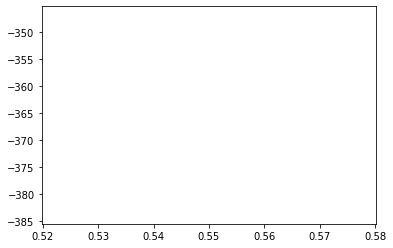

In [30]:
plt.plot(alpha_arr, ll)
print(ll)

In [25]:
%%time
alpha = alpha_arr[np.argmax(ll)]

ll = []
# rho = rho_arr[np.argmax(ll)]
beta_arr = np.linspace(0,50,11)
for beta in bet_arr:
    ratio = np.sqrt(1-rho)/np.sqrt(rho)
#     alpha = 1
#     beta = 0.5
    alpha2 = ratio*alpha
    beta2 = ratio*beta
    gamma = np.sqrt(alpha**2 - beta**2)
    mu1 = -beta*gamma**2/alpha**2
    mu2 = ratio*mu1
    delta1 = gamma**3/alpha**2
    delta2 = ratio*delta1

    X1_law = norminvgauss(alpha/np.sqrt(rho),beta/np.sqrt(rho),
                          -beta*gamma**2/np.sqrt(rho),gamma**3/(alpha**2*np.sqrt(rho)))
    X2_law = norminvgauss(alpha/np.sqrt(rho),beta/np.sqrt(rho),
                          -beta*gamma**2/np.sqrt(rho),gamma**3/(alpha**2*np.sqrt(rho)))
    e1_law = norminvgauss(alpha2,beta2,mu2,delta2)
    e2_law = norminvgauss(alpha2,beta2,mu2,delta2)

    A = []
    B = []
    for i in tqdm(range(len(U))):
        A.append(X1_law.ppf(U[i]))
        B.append(X2_law.ppf(V[i]))

    def joint_density_toopt(a, b, rho):
        part1 = 1/X1_law.pdf(a)
        part2 = 1/X2_law.pdf(b)

        part3a_fn = lambda m: e1_law.pdf((a-np.sqrt(rho)*m)/np.sqrt(1-rho))
        part3b_fn = lambda m: e2_law.pdf((b-np.sqrt(rho)*m)/np.sqrt(1-rho))
        part3 = scipy.integrate.quad(lambda m: part3a_fn(m)*part3b_fn(m),
                                     -np.inf, np.inf)[0]
        return part1*part2*part3

    result = []
    for i in tqdm(range(len(A))):
        result.append(joint_density_toopt(A[i], B[i], rho))
    result = np.array(result).reshape(-1)
    ll.append(np.nansum(np.log(result)))

NameError: name 'bet_arr' is not defined

ValueError: x and y must have same first dimension, but have shapes (11,) and (0,)

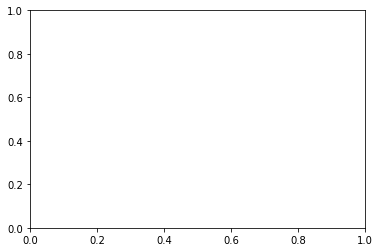

In [26]:
plt.plot(rho_arr, ll)
print(ll)

In [ ]:
# very nice paper about multivariate Hyperbolic Distribution
# https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.83.3969&rep=rep1&type=pdf